#第8章
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

**PyTorch** を使う

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/nlp100/'

#70. 単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xi
の特徴ベクトルxi
を並べた行列X
と，正解ラベルを並べた行列（ベクトル）Y
を作成したい．

仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

* 学習データの特徴量行列: Xtrain
* 学習データのラベルベクトル: Ytrain
* 検証データの特徴量行列: Xvalid
* 検証データのラベルベクトル: Yvalid
* 評価データの特徴量行列: Xtest
* 評価データのラベルベクトル: Ytest

In [3]:
!unzip /content/drive/MyDrive/nlp100/NewsAggregatorDataset.zip

Archive:  /content/drive/MyDrive/nlp100/NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [4]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk

nltk.download('punkt')
data_path = '/content/newsCorpora.csv'

publisheres = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
names = ["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"]
csv_input = pd.read_csv(data_path, sep="\t", header=None, names=names)

df = csv_input[csv_input["PUBLISHER"].isin(publisheres)]

df = df.sample(frac=1)

# 訓練：検証：評価=8:1:1に分割
x_train, x_valtest = train_test_split(df.values, test_size=0.2, random_state=0)
x_valid, x_test = train_test_split(x_valtest, test_size=0.5, random_state=0)
# option:strtify  ラベルの偏りをなくす

# FORMAT: ID \t TITLE \t URL \t PUBLISHER \t CATEGORY \t STORY \t HOSTNAME \t TIMESTAMP
def write_file(fname, x_data):
    with open(fname, "w")as fout:
        for fact in x_data:
            # fact[1] : 見出し
            # fact[4] : カテゴリ
            # b = business, t = science and technology, e = entertainment, m = health
            if fact[4] == 'b':
                label = '0'
            elif fact[4] == 't':
                label = '1'
            elif fact[4] == 'e':
                label = '2'
            elif fact[4] == 'm':
                label = '3'
            text = " ".join(nltk.word_tokenize(fact[1]))
            fout.write(label + '\t' + text + '\n')

write_file("train.txt", x_train)
write_file("valid.txt", x_valid)
write_file("test.txt", x_test)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
!gzip -d /content/drive/MyDrive/nlp100/GoogleNews-vectors-negative300.bin.gz

In [12]:
import gensim

model_path = '/content/drive/MyDrive/nlp100/GoogleNews-vectors-negative300.bin'
w2v = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [13]:
# import numpy as np
# # 学習データの特徴量行列: Xtrain
# # 学習データのラベルベクトル: Ytrain
# # 検証データの特徴量行列: Xvalid
# # 検証データのラベルベクトル: Yvalid
# # 評価データの特徴量行列: Xtest
# # 評価データのラベルベクトル: Ytest

def save_file(infname):
    with open(infname, "r") as fin:
        with open("X" + infname, "w") as fvec, open("Y" + infname, "w") as flabel:
            for line in fin:
                label, text = line.strip().split('\t')
                try:
                    mean = np.mean([w2v[word] for word in text.split(' ')], axis=1)
                    fvec.write(str(mean) + '\n')
                    flabel.write(label + '\n')
                except:
                    continue

save_file("train.txt")
save_file("valid.txt")
save_file("test.txt")

In [14]:
import numpy as np
import torch
# 学習データの特徴量行列: Xtrain
# 学習データのラベルベクトル: Ytrain
# 検証データの特徴量行列: Xvalid
# 検証データのラベルベクトル: Yvalid
# 評価データの特徴量行列: Xtest
# 評価データのラベルベクトル: Ytest

def create_data(infname):
    with open(infname, "r") as fin:
        vec = []
        y_label = []
        for line in fin:
            label, text = line.strip().split('\t')
            try:
                # mean = np.mean([w2v[word] for word in text.split(' ')], axis=1)
                tmp_vec = [w2v[word] for word in text.split(' ')]
                mean = sum(tmp_vec) / len(tmp_vec)

                # print(mean)
                vec.append(mean)
                y_label.append(int(label))
            except:
                continue
        return vec, y_label

x_train, y_train = create_data("train.txt")
x_valid, y_valid = create_data("valid.txt")
x_test, y_test = create_data("test.txt")

In [15]:
x_train[1]

array([-3.49426270e-02,  7.76443481e-02, -1.06109619e-01, -6.73103333e-03,
       -7.42797852e-02, -1.74560547e-02, -7.79266357e-02,  1.44271851e-02,
        1.27777100e-01,  1.64657593e-01, -1.80969238e-01,  1.21810913e-01,
        8.26339722e-02, -4.32128906e-02, -1.43234253e-01, -4.01210785e-02,
        1.52557373e-01, -8.52584839e-02,  1.49261475e-01, -8.38546753e-02,
        5.43646812e-02,  1.61239624e-01,  2.23510742e-01,  9.96398926e-02,
        8.88061523e-02,  5.37757874e-02,  2.61688232e-02,  7.83920288e-03,
        6.03637695e-02,  4.75540161e-02, -4.05578613e-02,  8.90197754e-02,
       -4.82444763e-02, -2.09442139e-01,  2.07834244e-02,  2.50244141e-02,
        1.40930176e-01, -1.24305725e-01, -1.51062012e-01,  2.16911316e-01,
        7.27005005e-02, -1.27293736e-01,  2.22290039e-01,  3.04718018e-02,
       -3.82080078e-02, -1.38122559e-01, -5.51528931e-02,  6.70299530e-02,
        2.63061523e-02,  1.53167725e-01, -4.95300293e-02,  2.96936035e-02,
        2.49938965e-02,  

In [16]:
#ファイルへの出力
import pickle

# ラベルもtensorに変換
train_t = torch.tensor(y_train).long()
valid_t = torch.tensor(y_valid).long()
test_t = torch.tensor(y_test).long()

with open('train.text.pickle', 'wb') as f:
    pickle.dump(x_train, f)
with open('train.label.pickle', 'wb') as f:
    pickle.dump(y_train, f)

with open('valid.text.pickle', 'wb') as f:
    pickle.dump(x_valid, f)
with open('valid.label.pickle', 'wb') as f:
    pickle.dump(y_valid, f)

with open('test.text.pickle', 'wb') as f:
    pickle.dump(x_test, f)
with open('test.label.pickle', 'wb') as f:
    pickle.dump(y_test, f)


#71. 単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．

In [17]:
#ネットワークの定義
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x):
    x = self.fc(x)
    return x

# ネットワークのインスタンスを作成
net = Net(300, 4)
net

Net(
  (fc): Linear(in_features=300, out_features=4, bias=False)
)

In [18]:
x_train = torch.from_numpy(np.array(x_train))
y_train = torch.from_numpy(np.array(y_train))

In [19]:
x = net(x_train[0])
x = torch.softmax(x, dim=-1)
x

tensor([0.6099, 0.1137, 0.0224, 0.2540], grad_fn=<SoftmaxBackward0>)

In [20]:
x = net(x_train[:4])
x = torch.softmax(x, dim=-1)
x

tensor([[0.6099, 0.1137, 0.0224, 0.2540],
        [0.1740, 0.3652, 0.0060, 0.4548],
        [0.7579, 0.1784, 0.0135, 0.0501],
        [0.0572, 0.8446, 0.0286, 0.0696]], grad_fn=<SoftmaxBackward0>)

In [21]:
# 乱数の初期化：いろんな初期化がある．初期値で性能が変わることもある．

#72. 損失と勾配の計算
学習データの事例x1
と事例集合x1,x2,x3,x4
に対して，クロスエントロピー損失と，行列W
に対する勾配を計算せよ．なお，ある事例xi
に対して損失は次式で計算される．

li=−log[事例xiがyiに分類される確率]
ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [22]:
import torch.nn as nn

# 損失の計算
criterion = nn.CrossEntropyLoss() # クロスエントロピーの中でsoftmaxの計算を計算を行っている．softmaxをかける前に入力する．
y = net(x_train[:1])
t = y_train[:1]
loss = criterion(y, t)

# 勾配の計算
net.zero_grad()
loss.backward()

print('損失 :', loss.item())
print('勾配 :')
print(net.fc.weight.grad)

損失 : 2.174081802368164
勾配 :
tensor([[-5.7567e-02,  9.8651e-04, -2.3088e-02,  ..., -1.0818e-02,
          6.0307e-03,  5.4699e-02],
        [ 8.3652e-02, -1.4335e-03,  3.3550e-02,  ...,  1.5720e-02,
         -8.7633e-03, -7.9483e-02],
        [-2.1141e-03,  3.6228e-05, -8.4787e-04,  ..., -3.9728e-04,
          2.2147e-04,  2.0087e-03],
        [-2.3971e-02,  4.1077e-04, -9.6136e-03,  ..., -4.5045e-03,
          2.5111e-03,  2.2776e-02]])


In [23]:
# 損失の計算
criterion = nn.CrossEntropyLoss()
y = net(x_train[:4])
t = y_train[:4]
loss = criterion(y, t)

# 勾配の計算
net.zero_grad()
loss.backward()

print('損失 :', loss.item())
print('勾配 :')
print(net.fc.weight.grad)

損失 : 1.765460729598999
勾配 :
tensor([[ 6.6994e-03, -1.5068e-02,  4.7925e-02,  ...,  2.4079e-03,
         -7.7614e-02,  3.7891e-02],
        [ 5.2649e-03,  6.2023e-03, -2.7448e-02,  ..., -5.6410e-03,
          4.5572e-02, -3.4224e-02],
        [-9.9748e-04,  8.4781e-05, -1.7079e-03,  ..., -3.1827e-04,
          1.2663e-03,  4.0103e-05],
        [-1.0967e-02,  8.7806e-03, -1.8770e-02,  ...,  3.5514e-03,
          3.0776e-02, -3.7070e-03]])


#73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [24]:
x_valid = torch.from_numpy(np.array(x_valid))
y_valid = torch.from_numpy(np.array(y_valid))
x_test = torch.from_numpy(np.array(x_test))
y_test = torch.from_numpy(np.array(y_test))

In [25]:
# ネットワークのインスタンスを作成
net = Net(300, 4)

#損失関数の選択
criterion = nn.CrossEntropyLoss()

#最適化手法の選択
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# モデルをGPUに転送
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
device

device(type='cpu')

In [26]:
#DataLoaderに格納

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train = TensorDataset(x_train, y_train)
val = TensorDataset(x_valid, y_valid)
test = TensorDataset(x_test, y_test)

batch_size = 10

train_loader = DataLoader(train, batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size, shuffle=False)
eval_loader = DataLoader(eval, batch_size, shuffle=False)

In [27]:
#学習ループ
max_epoch = 20

for epoch in range(max_epoch):

    # ミニバッチ学習
    for batch in train_loader:

        # バッチサイズ分のサンプルを抽出
        x, t = batch

        # データをGPUへ転送
        x = x.to(device)
        t = t.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)
        loss = criterion(y, t)

        # 誤差逆伝播
        loss.backward()
        optimizer.step()

    # 更新と切り離し、検証データの性能を確認
    with torch.no_grad():
        losses = list()
        for batch in val_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = net(x)
            loss = criterion(y, t)
            losses.append(loss)
    val_loss = torch.tensor(losses).mean()
    print("Epoch: %02d  val_loss: %.3f" % (epoch+1, val_loss))

Epoch: 01  val_loss: 0.624
Epoch: 02  val_loss: 0.502
Epoch: 03  val_loss: 0.466
Epoch: 04  val_loss: 0.431
Epoch: 05  val_loss: 0.412
Epoch: 06  val_loss: 0.404
Epoch: 07  val_loss: 0.409
Epoch: 08  val_loss: 0.392
Epoch: 09  val_loss: 0.395
Epoch: 10  val_loss: 0.409
Epoch: 11  val_loss: 0.411
Epoch: 12  val_loss: 0.425
Epoch: 13  val_loss: 0.420
Epoch: 14  val_loss: 0.423
Epoch: 15  val_loss: 0.411
Epoch: 16  val_loss: 0.425
Epoch: 17  val_loss: 0.430
Epoch: 18  val_loss: 0.426
Epoch: 19  val_loss: 0.444
Epoch: 20  val_loss: 0.432


#74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [28]:
from sklearn.metrics import accuracy_score

net.eval()
with torch.no_grad():
    losses = list()
    total = 0
    correct = 0

    for batch in val_loader:
        x, t = batch

        x = x.to(device)
        t = t.to(device)
        y = net(x)
        pred = torch.argmax(y, dim=-1)

        total += len(x)
        correct += (pred == t).sum().item()

print("valid 正解率: ", correct / total)

valid 正解率:  0.8402777777777778


In [29]:
net.eval()
with torch.no_grad():
    losses = list()
    total = 0
    correct = 0

    for batch in test_loader:
        x, t = batch

        x = x.to(device)
        t = t.to(device)
        y = net(x)
        pred = torch.argmax(y, dim=-1)

        total += len(x)
        correct += (pred == t).sum().item()

print("test 正解率: ", correct / total)

test 正解率:  0.8698224852071006


#75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [30]:
def calc_acc(loader):
    net.eval()
    with torch.no_grad():
        losses = list()
        total = 0
        correct = 0

        for batch in loader:
            x, t = batch

            x = x.to(device)
            t = t.to(device)
            y = net(x)
            pred = torch.argmax(y, dim=-1)

            total += len(x)
            correct += (pred == t).sum().item()
    return correct / total

In [31]:
# ネットワークのインスタンスを作成
net = Net(300, 4)

#損失関数の選択
criterion = nn.CrossEntropyLoss()

#最適化手法の選択
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# モデルをGPUに転送
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
device

device(type='cpu')

In [32]:
#学習ループ
max_epoch = 20

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(max_epoch):
    train_losses = list()
    # ミニバッチ学習
    for batch in train_loader:

        # バッチサイズ分のサンプルを抽出
        x, t = batch

        # データをGPUへ転送
        x = x.to(device)
        t = t.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)
        loss = criterion(y, t)


        # 誤差逆伝播
        loss.backward()
        optimizer.step()
        train_losses.append(loss)

    train_acc.append(calc_acc(train_loader))
    train_loss.append(torch.tensor(losses).mean())

    # 更新と切り離し、検証データの性能を確認
    with torch.no_grad():
        losses = list()
        for batch in val_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = net(x)
            loss = criterion(y, t)
            losses.append(loss)
    val_loss = torch.tensor(losses).mean()
    valid_loss.append(val_loss)
    valid_acc.append(calc_acc(val_loader))
    print("Epoch: %02d  val_loss: %.3f" % (epoch+1, val_loss))

Epoch: 01  val_loss: 0.655
Epoch: 02  val_loss: 0.520
Epoch: 03  val_loss: 0.450
Epoch: 04  val_loss: 0.418
Epoch: 05  val_loss: 0.419
Epoch: 06  val_loss: 0.406
Epoch: 07  val_loss: 0.386
Epoch: 08  val_loss: 0.383
Epoch: 09  val_loss: 0.368
Epoch: 10  val_loss: 0.369
Epoch: 11  val_loss: 0.366
Epoch: 12  val_loss: 0.360
Epoch: 13  val_loss: 0.371
Epoch: 14  val_loss: 0.364
Epoch: 15  val_loss: 0.384
Epoch: 16  val_loss: 0.378
Epoch: 17  val_loss: 0.376
Epoch: 18  val_loss: 0.384
Epoch: 19  val_loss: 0.394
Epoch: 20  val_loss: 0.380


In [33]:
print(len(train_loss))
print(len(train_acc))
print(len(valid_loss))
print(len(valid_acc))

20
20
20
20


In [34]:
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 33.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=5f662b18c91dc81bbb61748829a4e408a68030332d3d1b8c8e81171bd4d3d3f8
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


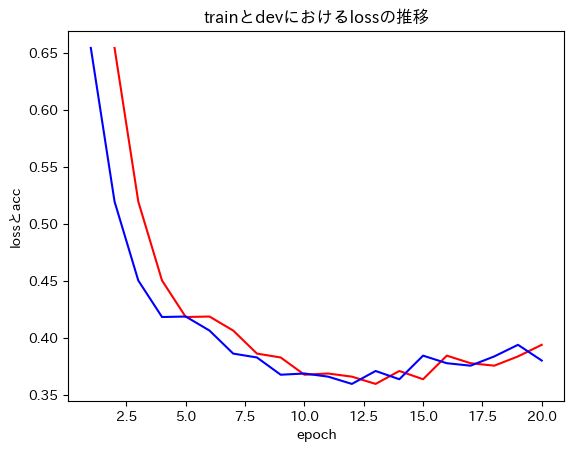

In [35]:
import matplotlib.pyplot as plt
import japanize_matplotlib

fig, ax = plt.subplots()
x = range(1, max_epoch+1)
ax.plot(x, train_loss,'r')
ax.plot(x, valid_loss, 'b')

plt.title('trainとdevにおけるlossの推移')
plt.xlabel("epoch")
plt.ylabel("lossとacc")

plt.show()

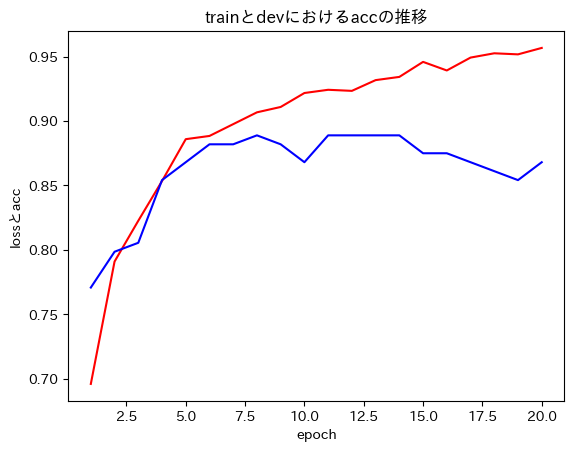

In [46]:
import matplotlib.pyplot as plt
import japanize_matplotlib

fig, ax = plt.subplots()
x = range(1, max_epoch+1)
ax.plot(x, train_acc, 'r')
ax.plot(x, valid_acc, 'b')

plt.title('trainとdevにおけるaccの推移')
plt.xlabel("epoch")
plt.ylabel("lossとacc")

plt.show()

#76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [37]:
# ネットワークのインスタンスを作成
net = Net(300, 4)

#損失関数の選択
criterion = nn.CrossEntropyLoss()

#最適化手法の選択
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# モデルをGPUに転送
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
device

device(type='cpu')

In [38]:
#学習ループ
max_epoch = 20

train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(max_epoch):
    train_losses = list()
    # ミニバッチ学習
    for batch in train_loader:

        # バッチサイズ分のサンプルを抽出
        x, t = batch

        # データをGPUへ転送
        x = x.to(device)
        t = t.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)
        loss = criterion(y, t)


        # 誤差逆伝播
        loss.backward()
        optimizer.step()
        train_losses.append(loss)

    train_acc.append(calc_acc(train_loader))
    train_loss.append(torch.tensor(losses).mean())

    # 更新と切り離し、検証データの性能を確認
    with torch.no_grad():
        losses = list()
        for batch in val_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = net(x)
            loss = criterion(y, t)
            losses.append(loss)
    val_loss = torch.tensor(losses).mean()
    valid_loss.append(val_loss)
    valid_acc.append(calc_acc(val_loader))
    print("Epoch: %02d  val_loss: %.3f" % (epoch+1, val_loss))
    # torch.save(net, 'model_checkpoint'+ str(epoch) + '.pt')
    torch.save({"epoch": epoch, "model_state_dict": net.state_dict(), "optimizer_state_dict": optimizer.state_dict(),},  'model_checkpoint'+ str(epoch) + '.pt')

Epoch: 01  val_loss: 0.680
Epoch: 02  val_loss: 0.517
Epoch: 03  val_loss: 0.457
Epoch: 04  val_loss: 0.441
Epoch: 05  val_loss: 0.411
Epoch: 06  val_loss: 0.388
Epoch: 07  val_loss: 0.387
Epoch: 08  val_loss: 0.366
Epoch: 09  val_loss: 0.381
Epoch: 10  val_loss: 0.393
Epoch: 11  val_loss: 0.367
Epoch: 12  val_loss: 0.379
Epoch: 13  val_loss: 0.368
Epoch: 14  val_loss: 0.363
Epoch: 15  val_loss: 0.378
Epoch: 16  val_loss: 0.400
Epoch: 17  val_loss: 0.391
Epoch: 18  val_loss: 0.407
Epoch: 19  val_loss: 0.408
Epoch: 20  val_loss: 0.402


#77. ミニバッチ化
問題76のコードを改変し，B
事例ごとに損失・勾配を計算し，行列W
の値を更新せよ（ミニバッチ化）．B
の値を1,2,4,8,…
と変化させながら，1エポックの学習に要する時間を比較せよ．

In [39]:
# ネットワークのインスタンスを作成
net = Net(300, 4)

#損失関数の選択
criterion = nn.CrossEntropyLoss()

#最適化手法の選択
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# モデルをGPUに転送
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
device

device(type='cpu')

In [40]:
#学習ループ
import time

max_epoch = 1

batch_size_list = [1, 2, 4, 8, 16, 32, 64, 256]

for batch_size in batch_size_list:
    train_loader = DataLoader(train, batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size, shuffle=False)
    test_loader = DataLoader(test, batch_size, shuffle=False)

    start = time.time()

    for epoch in range(max_epoch):

        # ミニバッチ学習
        for batch in train_loader:

            # バッチサイズ分のサンプルを抽出
            x, t = batch

            # 勾配を初期化
            optimizer.zero_grad()

            # 順伝播
            y = net(x)
            loss = criterion(y, t)
            train_loss.append(loss)

            # 誤差逆伝播
            loss.backward()
            optimizer.step()

        # 更新と切り離し、検証データの性能を確認
        with torch.no_grad():
            losses = list()
            for batch in val_loader:
                x, t = batch
                x = x.to(device)
                t = t.to(device)
                y = net(x)
                loss = criterion(y, t)
                losses.append(loss)
        val_loss = torch.tensor(losses).mean()
        # print("Epoch: %02d  val_loss: %.3f" % (epoch+1, val_loss))


        end = time.time()
        print("Epoch: %02d  time: %.3f" % (epoch+1, end-start))



Epoch: 01  time: 2.079
Epoch: 01  time: 1.370
Epoch: 01  time: 0.193
Epoch: 01  time: 0.115
Epoch: 01  time: 0.056
Epoch: 01  time: 0.037
Epoch: 01  time: 0.023
Epoch: 01  time: 0.017


#78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [41]:
# ネットワークのインスタンスを作成
net = Net(300, 4)

#損失関数の選択
criterion = nn.CrossEntropyLoss()

#最適化手法の選択
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# モデルをGPUに転送
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
device

device(type='cpu')

In [42]:
#学習ループ
max_epoch = 20


for epoch in range(max_epoch):

    # ミニバッチ学習
    for batch in train_loader:

        # バッチサイズ分のサンプルを抽出
        x, t = batch

        # データをGPUへ転送
        x = x.to(device)
        t = t.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)
        loss = criterion(y, t)
        train_loss.append(loss)

        # 誤差逆伝播
        loss.backward()
        optimizer.step()

    # 更新と切り離し、検証データの性能を確認
    with torch.no_grad():
        losses = list()
        for batch in val_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = net(x)
            loss = criterion(y, t)
            losses.append(loss)
    val_loss = torch.tensor(losses).mean()
    print("Epoch: %02d  val_loss: %.3f" % (epoch+1, val_loss))

Epoch: 01  val_loss: 1.922
Epoch: 02  val_loss: 1.599
Epoch: 03  val_loss: 1.440
Epoch: 04  val_loss: 1.335
Epoch: 05  val_loss: 1.223
Epoch: 06  val_loss: 1.105
Epoch: 07  val_loss: 1.003
Epoch: 08  val_loss: 0.928
Epoch: 09  val_loss: 0.872
Epoch: 10  val_loss: 0.825
Epoch: 11  val_loss: 0.785
Epoch: 12  val_loss: 0.751
Epoch: 13  val_loss: 0.721
Epoch: 14  val_loss: 0.695
Epoch: 15  val_loss: 0.672
Epoch: 16  val_loss: 0.651
Epoch: 17  val_loss: 0.632
Epoch: 18  val_loss: 0.616
Epoch: 19  val_loss: 0.602
Epoch: 20  val_loss: 0.589


#79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [43]:
#ネットワークの定義
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, input_size//2, bias=False)
    self.fc2 = nn.Linear(input_size//2, input_size//3, bias=True)
    self.fc3 = nn.Linear(input_size//3, output_size, bias=False)
    nn.init.normal_(self.fc.weight, 0.0, 1.0)  # 正規乱数で重みを初期化

  def forward(self, x):
    x = self.fc(x)
    return x

# ネットワークのインスタンスを作成
net = Net(300, 4)
net

Net(
  (fc): Linear(in_features=300, out_features=150, bias=False)
  (fc2): Linear(in_features=150, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=4, bias=False)
)

In [44]:
# ネットワークのインスタンスを作成
net = Net(300, 4)

#損失関数の選択
criterion = nn.CrossEntropyLoss()

#最適化手法の選択
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

# モデルをGPUに転送
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
device

device(type='cpu')

In [45]:
#学習ループ
max_epoch = 20


for epoch in range(max_epoch):

    # ミニバッチ学習
    for batch in train_loader:

        # バッチサイズ分のサンプルを抽出
        x, t = batch

        # データをGPUへ転送
        x = x.to(device)
        t = t.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝播
        y = net(x)
        loss = criterion(y, t)
        train_loss.append(loss)

        # 誤差逆伝播
        loss.backward()
        optimizer.step()

    # 更新と切り離し、検証データの性能を確認
    with torch.no_grad():
        losses = list()
        for batch in val_loader:
            x, t = batch
            x = x.to(device)
            t = t.to(device)
            y = net(x)
            loss = criterion(y, t)
            losses.append(loss)
    val_loss = torch.tensor(losses).mean()
    print("Epoch: %02d  val_loss: %.3f" % (epoch+1, val_loss))

Epoch: 01  val_loss: 5.291
Epoch: 02  val_loss: 4.289
Epoch: 03  val_loss: 3.460
Epoch: 04  val_loss: 2.789
Epoch: 05  val_loss: 2.247
Epoch: 06  val_loss: 1.799
Epoch: 07  val_loss: 1.433
Epoch: 08  val_loss: 1.173
Epoch: 09  val_loss: 1.017
Epoch: 10  val_loss: 0.933
Epoch: 11  val_loss: 0.881
Epoch: 12  val_loss: 0.837
Epoch: 13  val_loss: 0.792
Epoch: 14  val_loss: 0.749
Epoch: 15  val_loss: 0.711
Epoch: 16  val_loss: 0.680
Epoch: 17  val_loss: 0.655
Epoch: 18  val_loss: 0.634
Epoch: 19  val_loss: 0.618
Epoch: 20  val_loss: 0.604
